# Comparação entre redes

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import seaborn as sns
from statsmodels.tsa.stattools import acf

import locale

locale.setlocale(locale.LC_TIME, "pt_BR.UTF-8")

'pt_BR.UTF-8'

## Parametros

In [2]:
redes = ['MLP', 'CONV', 'LSTM', 'ESN']
# entrada   = [(1,2), (1,2,3,4), (1,2,3,4)] => [(MLP_1, MLP_2], (CONV1D_1_1,...1_2,...2_1,...2_2), (LSTM_1_1,...1_2,...2_1,...2_2)]
melhor_rede = [1, [1, 0], [2, 0]]
# entrada   = [(1,2), (1,2), (1,2), (1,2)]
subsistema = 'SECO'

## Configurações e rodadas

In [3]:
resultados = []
for idx, rede in enumerate(redes):
    if rede == 'ESN':
        print(f'./{rede}/resultado.pkl')
        with open(f"./{rede}/resultado.pkl", "rb") as f:
            resultados.append(pickle.load(f))
    elif rede == 'MLP':
        print(f'./{rede}/{melhor_rede[idx]}_camada/resultado.pkl')
        with open(f"./{rede}/{melhor_rede[idx]}_camada/resultado.pkl", "rb") as f:
            resultados.append(pickle.load(f))
    else:
        print(f'./{rede}/{rede}_{melhor_rede[idx][0]}_DENSO_{melhor_rede[idx][1]}/resultado.pkl')
        with open(f"./{rede}/{rede}_{melhor_rede[idx][0]}_DENSO_{melhor_rede[idx][1]+1}/resultado.pkl", "rb") as f:
            resultados.append(pickle.load(f))

./MLP/1_camada/resultado.pkl
./CONV/CONV_1_DENSO_0/resultado.pkl
./LSTM/LSTM_2_DENSO_0/resultado.pkl
./ESN/resultado.pkl


Teste de Wilcoxon Pareado
Estatística W: 630.0000
p-valor: 0.946606

Interpretação
Não há diferença estatisticamente significativa.
As duas redes são estatisticamente equivalentes.

Médias:
Configuração 1: m = 0.006065, dv= 0.000274
Configuração 2: m = 0.006061, dv= 0.000323
Teste de Wilcoxon Pareado
Estatística W: 101.0000
p-valor: 0.000000

Interpretação
Diferença estatisticamente significativa.
LSTM é estatisticamente MELHOR que a MLP.

Médias:
Configuração 1: m = 0.006065, dv= 0.000274
Configuração 2: m = 0.005789, dv= 0.000162
Teste de Wilcoxon Pareado
Estatística W: 0.0000
p-valor: 0.000000

Interpretação
Diferença estatisticamente significativa.
MLP é estatisticamente MELHOR que a ESN

Médias:
Configuração 1: m = 0.006065, dv= 0.000274
Configuração 2: m = 0.016238, dv= 0.009094
Teste de Wilcoxon Pareado
Estatística W: 128.0000
p-valor: 0.000000

Interpretação
Diferença estatisticamente significativa.
LSTM é estatisticamente MELHOR que a CONV.

Médias:
Configuração 1: m = 0.00606

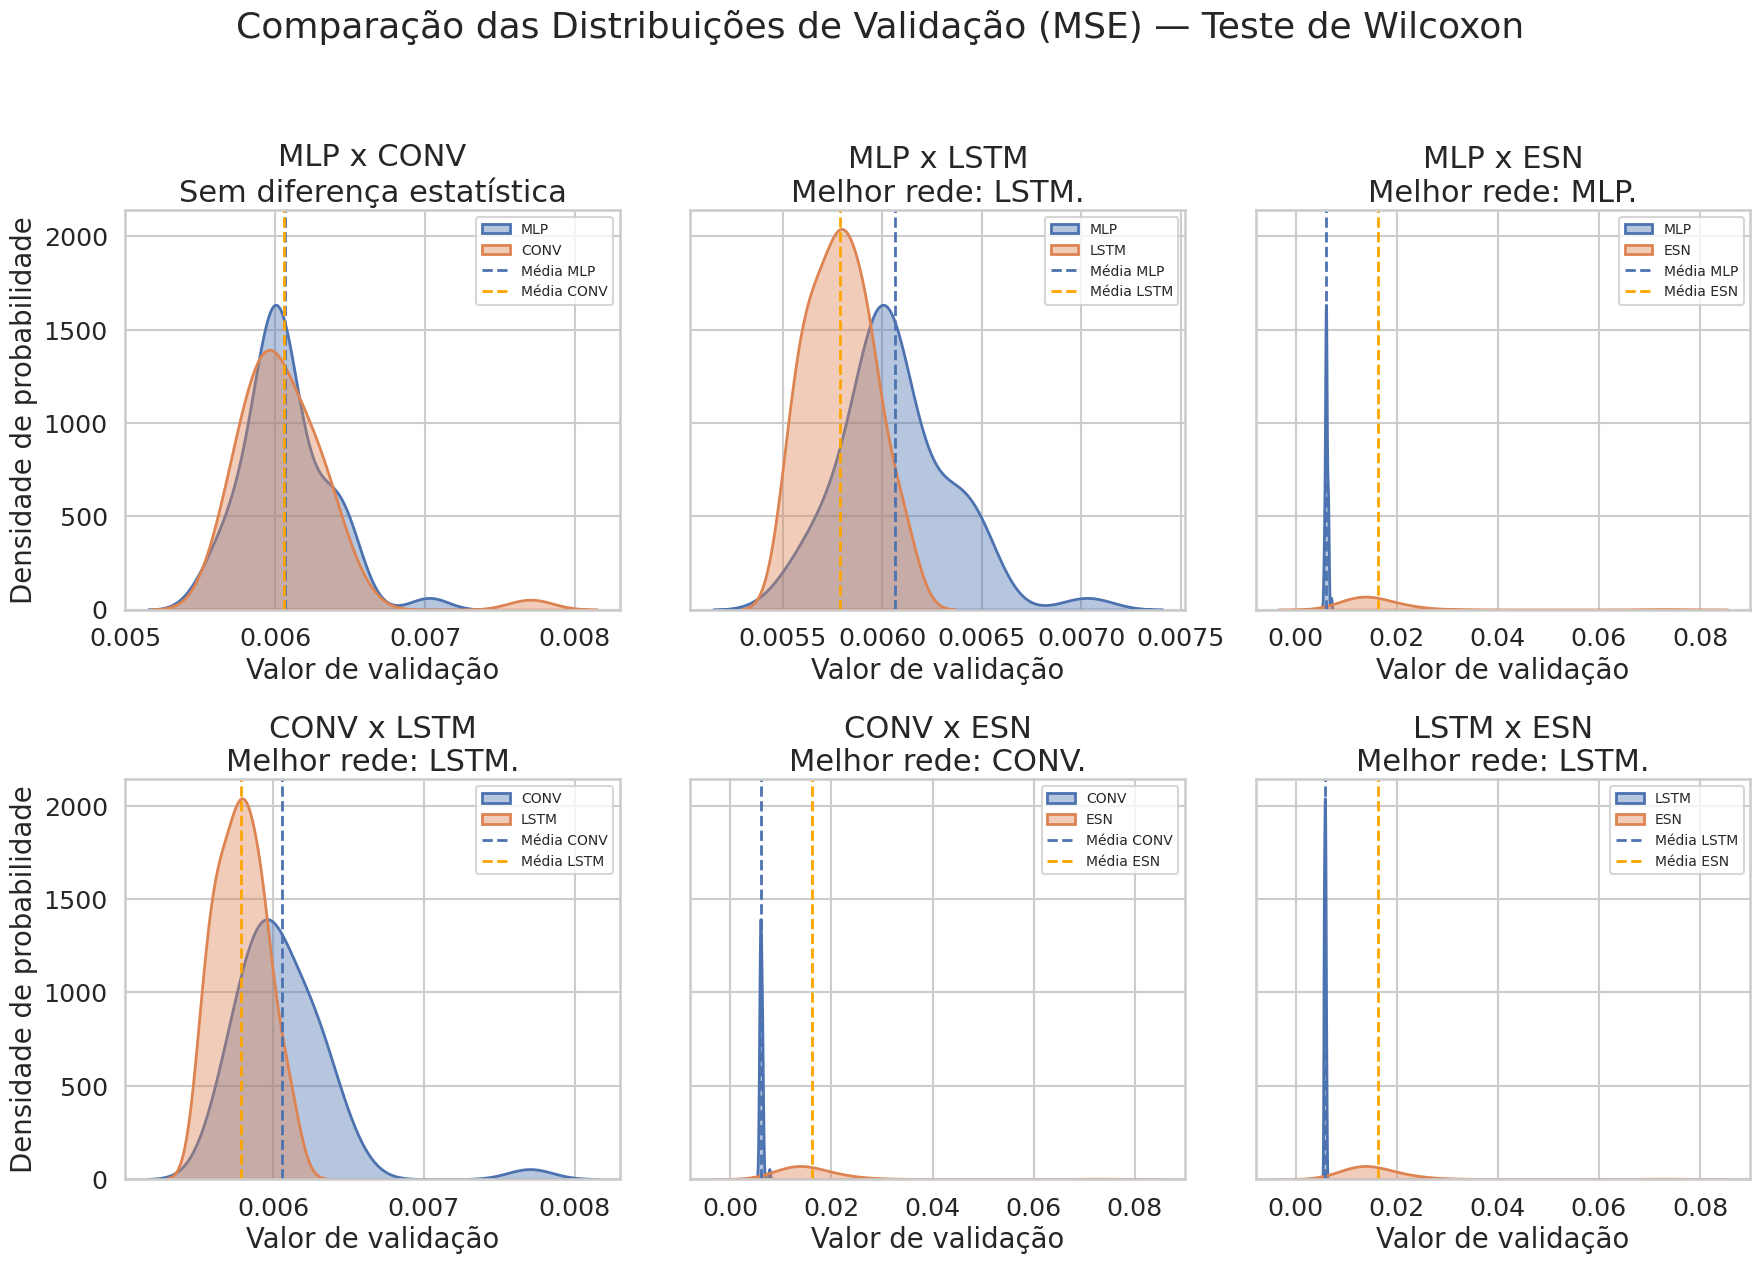

In [4]:
sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=1.1
)

fig, axes = plt.subplots(2, 3, figsize=(18, 13), sharey= 'all')
axes = axes.flatten()
alpha = 0.05
plot_idx = 0

for idx, rede in enumerate(redes):
    for jdx, rede_2 in enumerate(redes[idx+1:]):
        loss_configuracao_1 = np.array(resultados[idx]['normalizado']["mse"])
        loss_configuracao_2 = np.array(resultados[jdx+idx+1]['normalizado']["mse"])

        # TESTE DE WILCOXON
        stat, p_value = wilcoxon(loss_configuracao_1, loss_configuracao_2)

        print("Teste de Wilcoxon Pareado")
        print(f"Estatística W: {stat:.4f}")
        print(f"p-valor: {p_value:.6f}")

        # INTERPRETAÇÃO
        mean_1 = np.mean(loss_configuracao_1)
        mean_2 = np.mean(loss_configuracao_2)

        print("\nInterpretação")

        if p_value < alpha:
            if mean_1 < mean_2:
                print("Diferença estatisticamente significativa.")
                print(f"{rede} é estatisticamente MELHOR que a {rede_2}")
            elif mean_2 < mean_1:
                print("Diferença estatisticamente significativa.")
                print(f"{rede_2} é estatisticamente MELHOR que a {rede}.")
            else:
                print("Diferença estatisticamente significativa, mas as médias são iguais.")
        else:
            print("Não há diferença estatisticamente significativa.")
            print("As duas redes são estatisticamente equivalentes.")

        print("\nMédias:")
        print(f"Configuração 1: m = {mean_1:.6f}, dv= {np.std(loss_configuracao_1):.6f}")
        print(f"Configuração 2: m = {mean_2:.6f}, dv= {np.std(loss_configuracao_2):.6f}")

        ax = axes[plot_idx]

        sns.kdeplot(
            loss_configuracao_1,
            fill=True,
            alpha=0.4,
            linewidth=2,
            label=rede,
            ax=ax
        )

        sns.kdeplot(
            loss_configuracao_2,
            fill=True,
            alpha=0.4,
            linewidth=2,
            label=rede_2,
            ax=ax
        )

        # Médias
        ax.axvline(loss_configuracao_1.mean(), linestyle="--", linewidth=2, label=f"Média {rede}")
        ax.axvline(loss_configuracao_2.mean(), linestyle="--", linewidth=2, label=f"Média {rede_2}", color = 'orange')

        ax.set_xlabel("Valor de validação")
        ax.set_ylabel("Densidade de probabilidade")
        if p_value < alpha:
            if mean_1 < mean_2:
                ax.set_title(f"{rede} x {rede_2}\nMelhor rede: {rede}.", fontsize=22)
            elif mean_2 < mean_1:
                ax.set_title(f"{rede} x {rede_2}\nMelhor rede: {rede_2}.", fontsize=22)
        else:
            ax.set_title(f"{rede} x {rede_2}\nSem diferença estatística", fontsize=22)
        ax.legend(fontsize=10)

        plot_idx += 1

plt.suptitle(
    "Comparação das Distribuições de Validação (MSE) — Teste de Wilcoxon",
    fontsize=26
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    f"comparacao_redes_{subsistema}.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

## Analise de desempenho do melhor modelo

In [5]:
melhor_rede = [3]

In [6]:
datas = pd.date_range(
    start="2025-01-01 00:00",
    end="2025-12-31 23:00",
    freq="h"
)

In [7]:
df = pd.DataFrame({
    "real": resultados[melhor_rede[0]-1]['y_true'][:8760],
    "pred": resultados[melhor_rede[0]-1]['y_pred'][:8760]
}, index=datas)

df["residuo"] = df["real"] - df["pred"]

In [8]:
df["ape"] = np.abs((df["real"] - df["pred"]) / df["real"]) * 100

mape_mensal = df["ape"].resample("ME").mean()

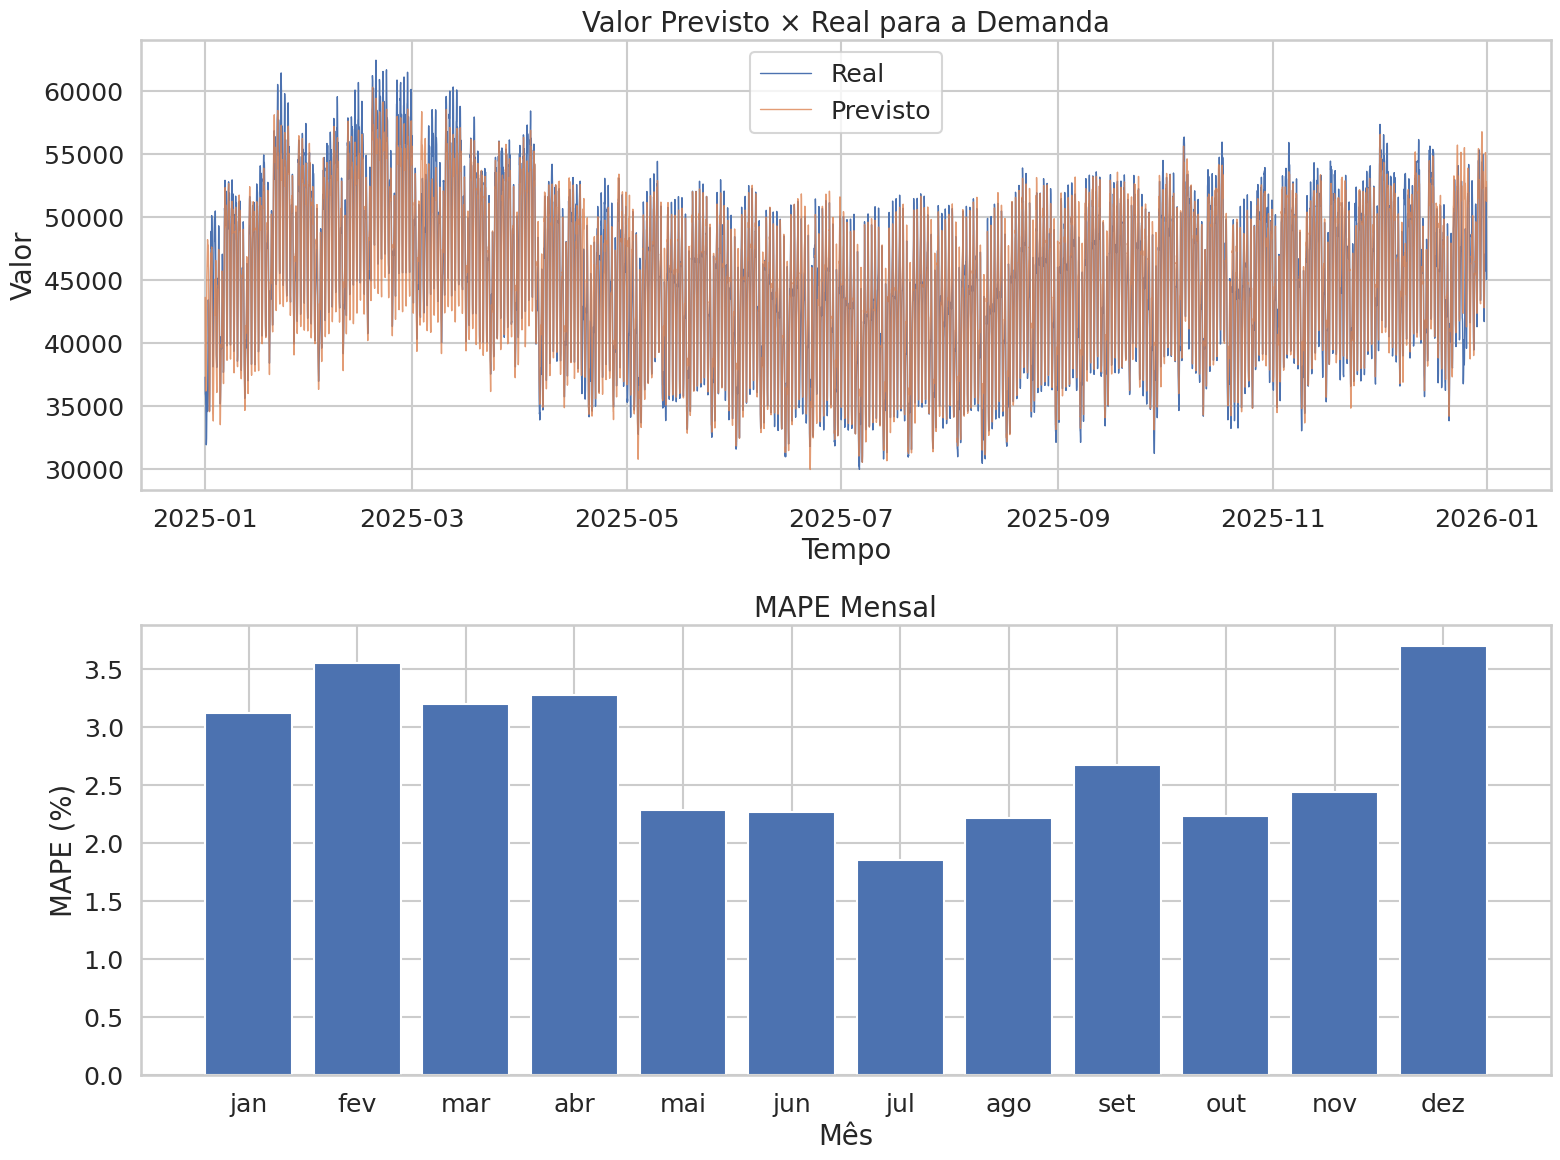

In [9]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(16, 12)
)

axes[1].bar(
    mape_mensal.index.strftime("%b"),
    mape_mensal.values
)

axes[1].set_xlabel("Mês")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_title("MAPE Mensal")
axes[1].grid(True)


axes[0].plot(df.index, df["real"], label="Real", linewidth=1)
axes[0].plot(df.index, df["pred"], label="Previsto", linewidth=1, alpha=0.8)

axes[0].set_xlabel("Tempo")
axes[0].set_ylabel("Valor")
axes[0].set_title("Valor Previsto × Real para a Demanda")
axes[0].legend()
axes[0].grid(True)


plt.tight_layout()

plt.savefig(
    f"mape_rede_{subsistema}.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

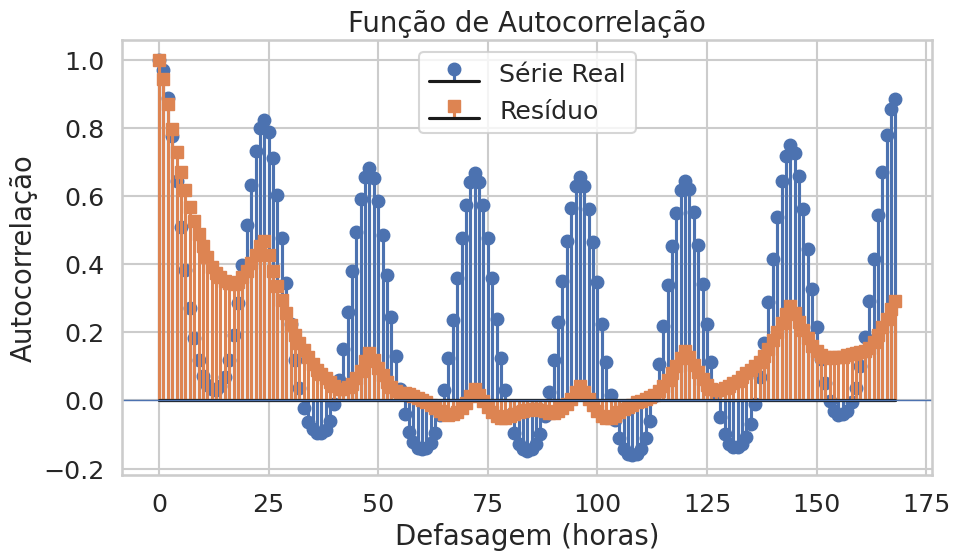

In [10]:
plt.figure(figsize=(10, 6))
acf_vals = acf(df["residuo"], nlags=168)  # 168 = 1 semana (dados horários)
acf_true = acf(df["real"], nlags=168) 

markerline2, stemlines2, baseline2 = plt.stem(
    range(len(acf_true)), acf_true, linefmt='C0-', markerfmt='C0o', basefmt='k-'
)
markerline1, stemlines1, baseline1 = plt.stem(
    range(len(acf_vals)), acf_vals, linefmt='C1-', markerfmt='C1s', basefmt='k-'
)


plt.xlabel("Defasagem (horas)")
plt.ylabel("Autocorrelação")
plt.title("Função de Autocorrelação")
plt.legend(["Série Real", "Resíduo"])
plt.axhline(0, linewidth=1)
plt.tight_layout()
plt.savefig(
    f"acf_{subsistema}.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
